In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import re
from textblob import TextBlob
from scipy.stats import chi2_contingency
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phurb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phurb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Objectives:
* 1)What is top most commnly stated issue?
* 2)Which month of year issue seems to be high?
* 3)Which part seems to address issue and what kind of issue?
* 4)How was complaint submitted?
* 5)Time taken by company to solve dispute?
* 6)Company with highest issue and corresponding dispute?


# Objectives 2:
* Common type of complaint catagoreis that are frequent.
* Trend Analysis
* Sentiment analysis
* Rootcause analysis
* geographical analysis
* Comparision analysis
* Customer satisfication analysis
* Recommendation and improvement


### Credit Cards Complaints Analysis.
Complaints regarding credit cards issues is very important to insure improve customer experinece and understand the potential issues.
Here, I have made and ettempt to analyze "Credit Cards Complaints" dataset which is available at "Data World". 

Here are a few observations I made while examining the data:
* Frequency of Complaints submitted between year 2011 to early 2017.
* Medium preferred by customer to submit complaints.
* Types of issues that occured most.
* Response of company and reaction of customer
* Why did customer disputed and its reason.

First, read a CSV dataset containing credit card complaints from a provided URL and save it as `credit_cards_complaints`. Then, we can display the top section of the dataset to examine its contents.

In [2]:
#Read csv from url and save it as credit_cards_complaints.
credit_cards_complaints = pd.read_csv('https://query.data.world/s/22w5bmog7env6wmc37wv27mjjtk2rf?dws=00000')
credit_cards_complaints.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/29/2013,Credit card,NaN,Billing statement,NaN,NaN,NaN,Citibank,OH,45247,NaN,NaN,Referral,07/30/2013,Closed with explanation,Yes,Yes,469026
1,07/29/2013,Credit card,NaN,APR or interest rate,NaN,NaN,NaN,Synchrony Financial,WA,98548,NaN,NaN,Web,07/29/2013,Closed with monetary relief,Yes,No,469131
2,07/29/2013,Credit card,NaN,Delinquent account,NaN,NaN,NaN,Amex,TX,78232,NaN,NaN,Web,07/29/2013,Closed with monetary relief,Yes,No,479990
3,07/29/2013,Credit card,NaN,Billing disputes,NaN,NaN,NaN,Capital One,FL,32226,Servicemember,NaN,Web,07/29/2013,Closed with explanation,Yes,No,475777
4,07/29/2013,Credit card,NaN,Credit line increase/decrease,NaN,NaN,NaN,Citibank,WI,53066,Older American,NaN,Phone,07/30/2013,Closed with explanation,Yes,Yes,469473


Summarize the data types of each column, the number of non-null values, and other details such as memory usage.


In [3]:
credit_cards_complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87718 entries, 0 to 87717
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date received                 87718 non-null  object 
 1   Product                       87718 non-null  object 
 2   Sub-product                   0 non-null      float64
 3   Issue                         87718 non-null  object 
 4   Sub-issue                     0 non-null      float64
 5   Consumer complaint narrative  17433 non-null  object 
 6   Company public response       19956 non-null  object 
 7   Company                       87718 non-null  object 
 8   State                         86980 non-null  object 
 9   ZIP code                      86980 non-null  object 
 10  Tags                          13258 non-null  object 
 11  Consumer consent provided?    29563 non-null  object 
 12  Submitted via                 87717 non-null  object 
 13  D

Drop sub-product and sub-issue column as it has zero data and is not relevant in our further analysis.

In [4]:
#Selecting columns to drop with respect to its index.
#Columns at index 2,4 will be dropped which are null columns.
columns_to_drop = [credit_cards_complaints.columns[2], credit_cards_complaints.columns[4]]
credit_cards_complaints.drop(columns_to_drop, axis=1, inplace=True)

#Summarize
credit_cards_complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87718 entries, 0 to 87717
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 87718 non-null  object
 1   Product                       87718 non-null  object
 2   Issue                         87718 non-null  object
 3   Consumer complaint narrative  17433 non-null  object
 4   Company public response       19956 non-null  object
 5   Company                       87718 non-null  object
 6   State                         86980 non-null  object
 7   ZIP code                      86980 non-null  object
 8   Tags                          13258 non-null  object
 9   Consumer consent provided?    29563 non-null  object
 10  Submitted via                 87717 non-null  object
 11  Date sent to company          87718 non-null  object
 12  Company response to consumer  87718 non-null  object
 13  Timely response?

Now we have the only columns that are needed and is not null, but name of column seems to be messy. So we now try to clean column name and make it easier for future analysis.Also, we create new column 'no_of_days_taken_to_respond' by substracting date_sent_to_company column and date_received column.Then sort the values by date_received and summarize the dataset.

In [5]:
#converting all column name into lower case.
#using regex to replace columns with special characters and space
credit_cards_complaints.columns = credit_cards_complaints.columns.str.lower().\
str.replace(r'\s+','_',regex=True).str.replace(r'\?','',regex = True)

#create a new column 'no_of_days_taken_to_respond' and add days as integer.
credit_cards_complaints['no_days_taken_to_respond']=(pd.to_datetime(credit_cards_complaints.date_sent_to_company)\
    -pd.to_datetime(credit_cards_complaints.date_received)).dt.days.astype(int)

#sorting values by date_received column
credit_cards_complaints.sort_values(by = 'date_received')

,date_received,product,issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,no_days_taken_to_respond
63609,01/01/2012,Credit card,Payoff process,NaN,NaN,Citibank,CA,94403,NaN,NaN,Web,01/03/2012,Closed with relief,Yes,No,9002,2
63654,01/01/2012,Credit card,Collection practices,NaN,NaN,Capital One,AZ,85254,NaN,NaN,Web,01/03/2012,Closed without relief,Yes,No,70492,2
30292,01/01/2012,Credit card,Billing disputes,NaN,NaN,Citibank,NC,28443,NaN,NaN,Web,01/03/2012,Closed with relief,Yes,No,5171,2
33348,01/01/2013,Credit card,Credit reporting,NaN,NaN,Capital One,NJ,08043,NaN,NaN,Web,02/04/2013,Closed with non-monetary relief,Yes,No,219508,34
50564,01/01/2013,Credit card,Advertising and marketing,NaN,NaN,Capital One,VA,24503,NaN,NaN,Web,01/03/2013,Closed with explanation,Yes,Yes,220218,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85337,12/31/2016,Credit card,Credit determination,NaN,Company has responded to the consumer and the ...,Citibank,KY,42701,"Older American, Servicemember",Consent not provided,Web,01/03/2017,Closed with explanation,Yes,Yes,2270561,3
76530,12/31/2016,Credit card,Billing disputes,the aqcct has disability insurance but seventh...,Company believes it acted appropriately as aut...,"Colony Brands, Inc.",NY,112XX,Older American,Consent provided,Web,01/03/2017,Closed,No,No,2270647,3
72925,12/31/2016,Credit card,Billing statement,Wells Fargo does not show the customer the sta...,Company has responded to the consumer and the ...,Wells Fargo & Company,TX,752XX,NaN,Consent provided,Web,12/31/2016,Closed with explanation,No,No,2270321,0
86635,12/31/2016,Credit card,Privacy,I am a credit card holder of the retail depart...,Company has responded to the consumer and the ...,Citibank,PA,191XX,NaN,Consent provided,Web,12/31/2016,Closed with explanation,Yes,Yes,2270705,0


In [6]:
credit_cards_complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87718 entries, 0 to 87717
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 87718 non-null  object
 1   product                       87718 non-null  object
 2   issue                         87718 non-null  object
 3   consumer_complaint_narrative  17433 non-null  object
 4   company_public_response       19956 non-null  object
 5   company                       87718 non-null  object
 6   state                         86980 non-null  object
 7   zip_code                      86980 non-null  object
 8   tags                          13258 non-null  object
 9   consumer_consent_provided     29563 non-null  object
 10  submitted_via                 87717 non-null  object
 11  date_sent_to_company          87718 non-null  object
 12  company_response_to_consumer  87718 non-null  object
 13  timely_response 

Now check out unique value counts for each column to see the number of unique values present in each column.

In [7]:
credit_cards_complaints.nunique()

date_received                    1956
product                             1
issue                              33
consumer_complaint_narrative    17376
company_public_response            10
company                           421
state                              62
zip_code                        15588
tags                                3
consumer_consent_provided           4
submitted_via                       6
date_sent_to_company             1868
company_response_to_consumer        8
timely_response                     2
consumer_disputed                   2
complaint_id                    87718
no_days_taken_to_respond          214
dtype: int64

Created a new DataFrame called max_complaints_received where I grouped the credit_cards_complaints DataFrame by the 'date_received' column and stored the result in a new column called 'no_of_complaints'. 

Next, I extracted the month and year from the 'date_received' column and grouped the data again by 'date_received'. This time, I used the sum() function to calculate the total number of complaints for each grouped date.

In [8]:
#group number of complaints received by date_received and counted each rows and saved the result as no_complaints.
max_complaints_received = credit_cards_complaints.groupby("date_received").size().rename("no_complaints").reset_index()

#convert date_received to datetime format,extract month and year and get sum of no_complaints by 'date received' 
max_complaints_received["date_received"] = pd.to_datetime(max_complaints_received["date_received"]).dt.strftime("%m/%Y")
max_complaints_received = max_complaints_received.groupby("date_received").sum("no_complaints").reset_index()

#for sorting according to year and month created month and year column temporarily.
max_complaints_received["month"] = pd.to_datetime(max_complaints_received["date_received"]).dt.month
max_complaints_received["year"] = pd.to_datetime(max_complaints_received["date_received"]).dt.year
#sorted by year and month.
max_complaints_received = max_complaints_received.sort_values(by = ['year','month'])

#dropped the month and year column
complaints = max_complaints_received.drop(columns = ['month','year']).reset_index(drop = True)
complaints = complaints[~complaints['date_received'].str.endswith("04/2017")]
complaints.tail()

,date_received,no_complaints
59,11/2016,1732
60,12/2016,1823
61,01/2017,1893
62,02/2017,1828
63,03/2017,1897


Now we will plot frequency of the complaints made between year 2011 to 3/2017.

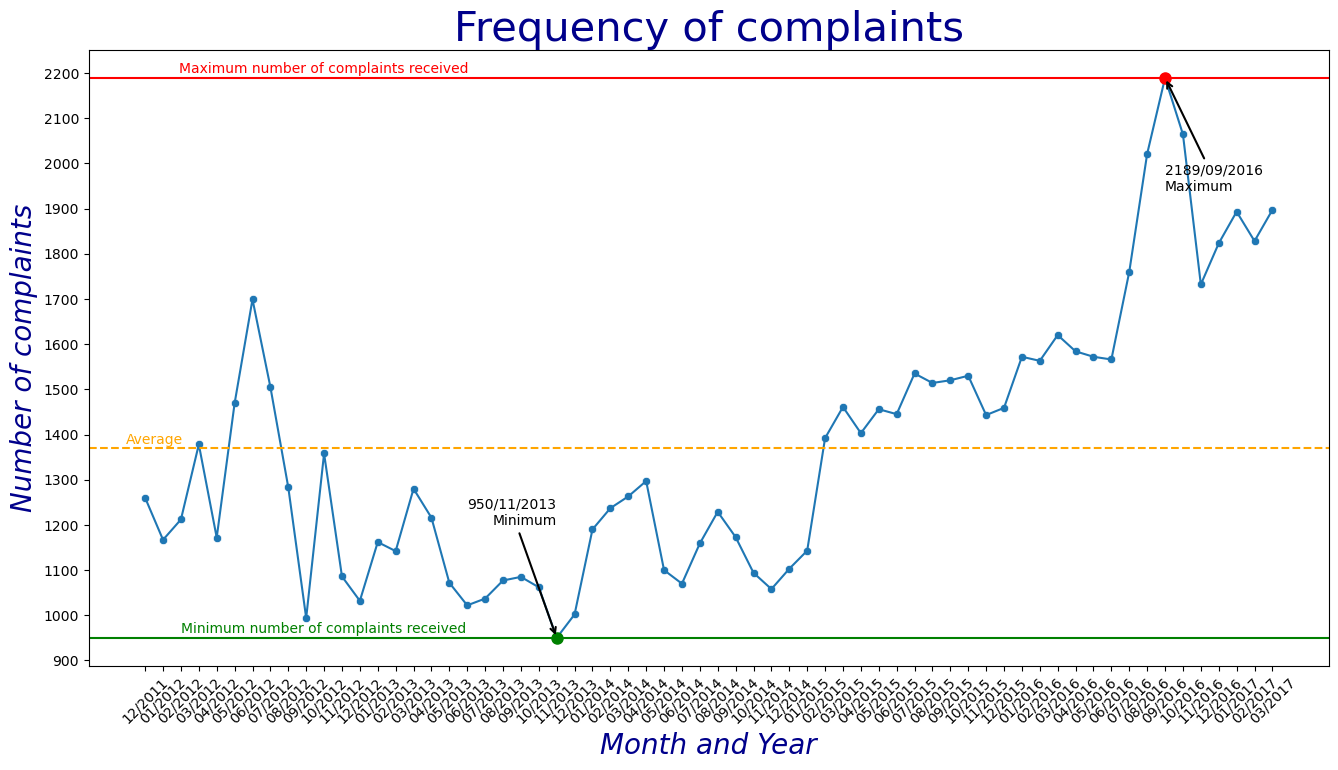

In [9]:
# Creating a figure and axes and with figsize.
fig, ax = plt.subplots(figsize=(16, 8))

# Scatter plot of complaints with date_received on the x-axis and no_complaints on the y-axis
sns.scatterplot(data=complaints, x='date_received', y='no_complaints', ax=ax)

# line plot to connect the scatter plot points
sns.lineplot(data=complaints, x='date_received', y='no_complaints', ax=ax)

# Setting title and format of the plot
ax.set_title("Frequency of complaints", fontsize=30, fontstyle='normal', color='darkblue')

# Setting the labels and format of the x-axis
ax.set_xlabel("Month and Year", fontsize=20, fontstyle='italic', color='darkblue')
plt.xticks(rotation=45)
plt.xticks(complaints.date_received, fontsize=10)

# Setting labels and format
ax.set_ylabel("Number of complaints", fontsize=20, fontstyle='italic', color='darkblue')
plt.yticks(range(0, complaints.no_complaints.max() + 200)[::100], fontsize=10)

# Calculating the average, minimum, and maximum
avg = complaints.no_complaints.mean()
minn = complaints.no_complaints.min()
maxx = complaints.no_complaints.max()

# Horizontal lines and text for average, minimum, and maximum
ax.axhline(avg, linestyle='--', color='orange', label="Average")
ax.text(0.5, avg + 10, 'Average', ha='center', color='orange')
ax.axhline(minn, linestyle='-', color='g', label="Minimum")
ax.text(10, minn + 10, 'Minimum number of complaints received', ha="center", color='g')
ax.axhline(maxx, linestyle='-', color='r', label='Maximum')
ax.text(10, maxx +10, 'Maximum number of complaints received', ha='center', color='r')

# Maximum and minimum number of complaints and date
max_date = complaints.date_received[complaints.no_complaints == complaints.no_complaints.max()].values[0]
min_date = complaints.date_received[complaints.no_complaints == complaints.no_complaints.min()].values[0]

# Markers and annotations for maximum and minimum points
ax.plot(min_date, minn, marker='o', markersize=8, color='green')
ax.plot(max_date, maxx, marker='o', markersize=8, color='red')
ax.annotate(f'{maxx}/{max_date}\nMaximum', xy=(max_date, maxx), xytext=(max_date, maxx - 250),
            arrowprops=dict(arrowstyle="->", linewidth=1.5), fontsize=10)
ax.annotate(f'{minn}/{min_date}\nMinimum', xy=(min_date, minn), xytext=(min_date, minn + 250),
            arrowprops=dict(arrowstyle='->', linewidth=1.5), ha='right')
plt.show()

Now, we plot top 10 issues registered by the customers to check which is most occured issues.

In [10]:
#Counting number of unique issues.
company_issues = credit_cards_complaints.issue.value_counts().reset_index()
company_issues.columns = ['issue', 'counts']

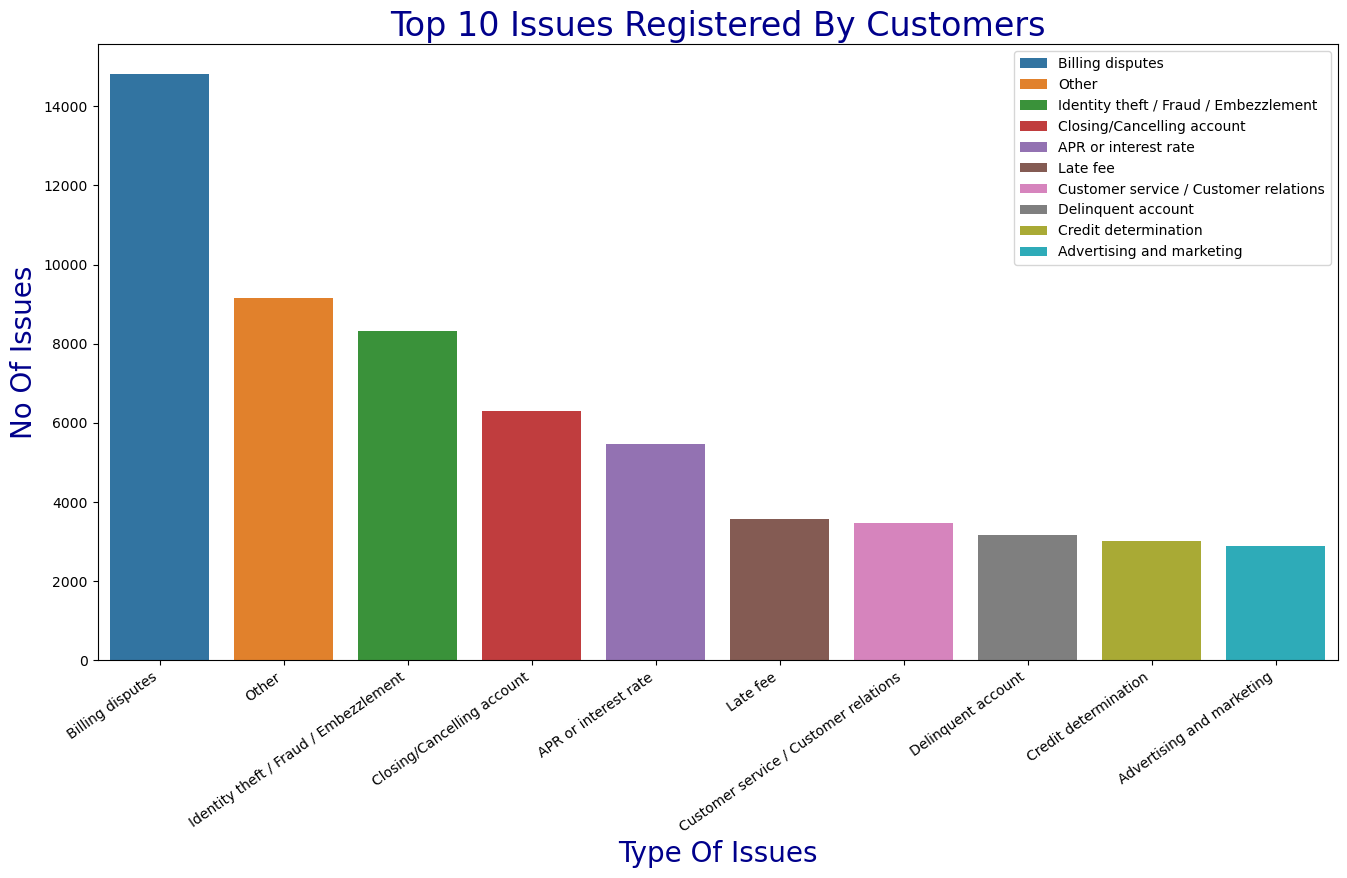

In [11]:
#Creating bar plot.
plt.figure(figsize = (16,8))
sns.barplot(data=company_issues.head(10), x='issue', y='counts',label = company_issues.issue.head(10))
#Setting label and format
plt.title("Top 10 Issues Registered By Customers",fontsize = 24,color = 'darkblue')
plt.xlabel("Type Of Issues",fontsize = 20,color = 'darkblue')
plt.xticks(rotation=35,ha = 'right')
legend = plt.legend(loc = 'upper right')

plt.ylabel("No Of Issues",fontsize = 20,color = "darkblue")
plt.show()

In [12]:
#Create new dataframe form credit_cards_complaints with selected columns.
response_dispute = credit_cards_complaints[['company_response_to_consumer',
                                           'timely_response',
                                           'consumer_disputed',
                                           'submitted_via']]
#create submitted_via df from response dispute by counting values.
submitted_via = response_dispute.submitted_via.value_counts().reset_index()

#renamed submitted_via df columns
submitted_via.columns = ['submitted_via','submission_count']

Now ploted top used medium preferred by the customer to address complaints.

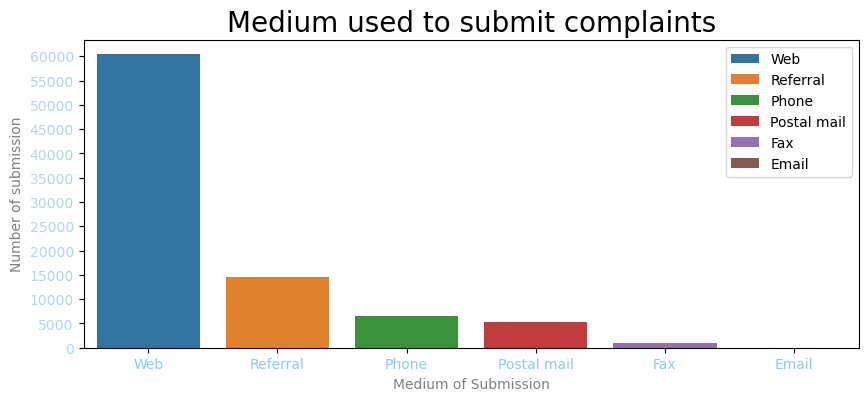

In [13]:
#create figure and setting figure size.
plt.figure(figsize = (10,4))

#Creating barplot.
sns.barplot(submitted_via,x = 'submitted_via', y = 'submission_count',\
            label =submitted_via.submitted_via)

#Setting Labels and format of the plot
plt.title("Medium used to submit complaints",fontsize = 20)
plt.xticks(color = 'skyblue')
plt.xlabel("Medium of Submission",color = 'gray')
plt.yticks(range(0,submitted_via.submission_count.max()+200)[::5000],color = 'lightblue')
plt.ylabel("Number of submission",color = 'gray')

#creating legends.
legends = plt.legend(loc = 'upper right')

plt.show()

Now we will look at response of the company to the issue addressed by the customer and how customer reacted to it. We will use chi-square test to find relation between company response and customer reaction,company response time and customer reaction. Here, as p-value we take standard p-value of "0.05" and compare our p-value with it. If p-value is less than 0.05 we reject null-hypothesis and if p-value is greater than "0.05" we reject alternative hypothesis.

In [14]:
#Create df rd_count 
rd_count = response_dispute.reset_index()
rd_count[['company_response_to_consumer','timely_response','consumer_disputed']]

#create contingency_table.
contingency_table = pd.crosstab(index=[rd_count['company_response_to_consumer'], \
                                       rd_count['timely_response']],\
                                columns=rd_count['consumer_disputed'])
contingency_table


consumer_disputed                                   No    Yes
company_response_to_consumer    timely_response              
Closed                          No                  14      5
                                Yes                464    133
Closed with explanation         No                 269     92
                                Yes              36385  13461
Closed with monetary relief     No                  79     10
                                Yes              15408   1934
Closed with non-monetary relief No                  39     15
                                Yes               7725   1092
Closed with relief              No                  74      7
                                Yes               2147    277
Closed without relief           No                  76     19
                                Yes               3159   1024

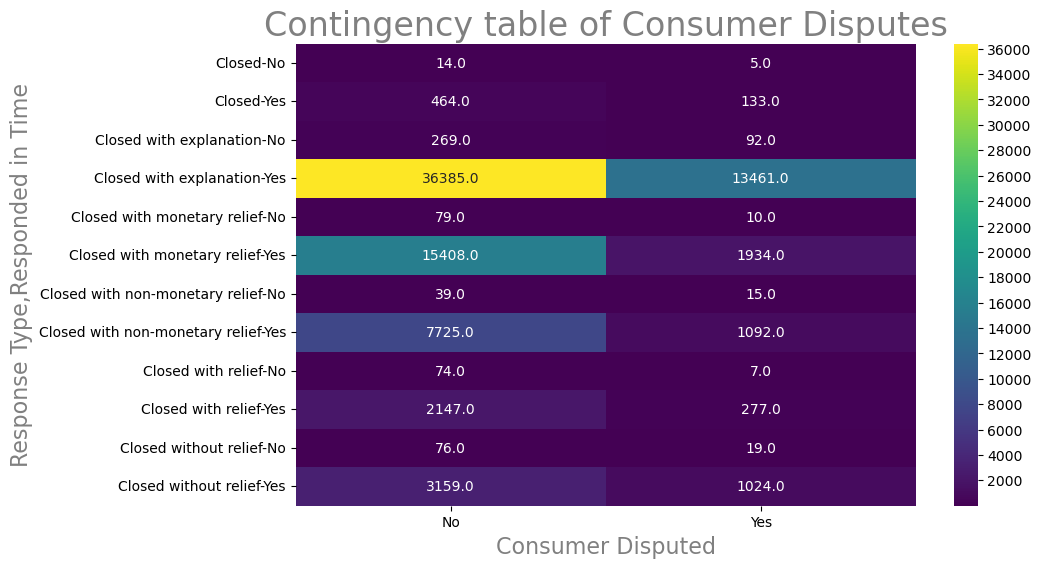

In [15]:
#create figure and set figure size
plt.figure(figsize = (10,6))

#create heatmap
sns.heatmap(contingency_table, annot=True, fmt = '.1f',\
            cmap='viridis',cbar_kws={'ticks': range(0,38001,2000)})

#Setting label and format of the plot
plt.title("Contingency table of Consumer Disputes", ha='center',fontsize = 24,color = 'gray')
plt.xlabel("Consumer Disputed",fontsize = 16,color = 'gray')
plt.ylabel("Response Type,Responded in Time",fontsize = 16,color = 'gray')
plt.show()

Here, we define the null hypothesis and alternative hypothesis as follows:

- Null hypothesis: There is no relationship between the response type and response time with customer disputes.
- Alternative hypothesis: There is a relationship between the response type and response time with customer disputes.

In [16]:
#perform chi-square test on the contingency table created
chi_f,p_value_f,dof_f,expected_f = chi2_contingency(contingency_table)
print("Chi-test: ",chi_f)
print("P-value: ",p_value_f)
print("Degree of freedom: ",dof_f)

#create small 100 lines
print("-"*100)

#create expected_f df
expected_f = pd.DataFrame(expected_f)

#set index and columns of expected_f df as contingency table
expected_f.index = contingency_table.index
expected_f.columns = contingency_table.columns
print(expected_f)

Chi-test:  2612.7557189104245
P-value:  0.0
Degree of freedom:  11
----------------------------------------------------------------------------------------------------
consumer_disputed                                          No           Yes
company_response_to_consumer    timely_response                            
Closed                          No                  14.908483      4.091517
                                Yes                468.440232    128.559768
Closed with explanation         No                 283.261179     77.738821
                                Yes              39112.013086  10733.986914
Closed with monetary relief     No                  69.834473     19.165527
                                Yes              13607.521786   3734.478214
Closed with non-monetary relief No                  42.371478     11.628522
                                Yes               6918.320816   1898.679184
Closed with relief              No                  63.557217     17.442

As we see that from our chi-square test there is a significant relationship between how company respondes and disputes.Hence we reject null hypothesis and accept alternative hypothesis.

Now, again we perform chi-square test with company_response_type and consumer dispute and see if there is significant relationship. Also we will perfomr chi-square test with company response time and consumer dispute

In [17]:
#create another contingency table "contingency_table_response_type_vs_consumer_dispute "
contingency_table_response_type_vs_consumer_dispute = pd.crosstab(index=rd_count['company_response_to_consumer'],\
                                                                 columns=rd_count['consumer_disputed'])
contingency_table_response_type_vs_consumer_dispute 

consumer_disputed,No,Yes
company_response_to_consumer,,
Closed,478,138
Closed with explanation,36654,13553
Closed with monetary relief,15487,1944
Closed with non-monetary relief,7764,1107
Closed with relief,2221,284
Closed without relief,3235,1043


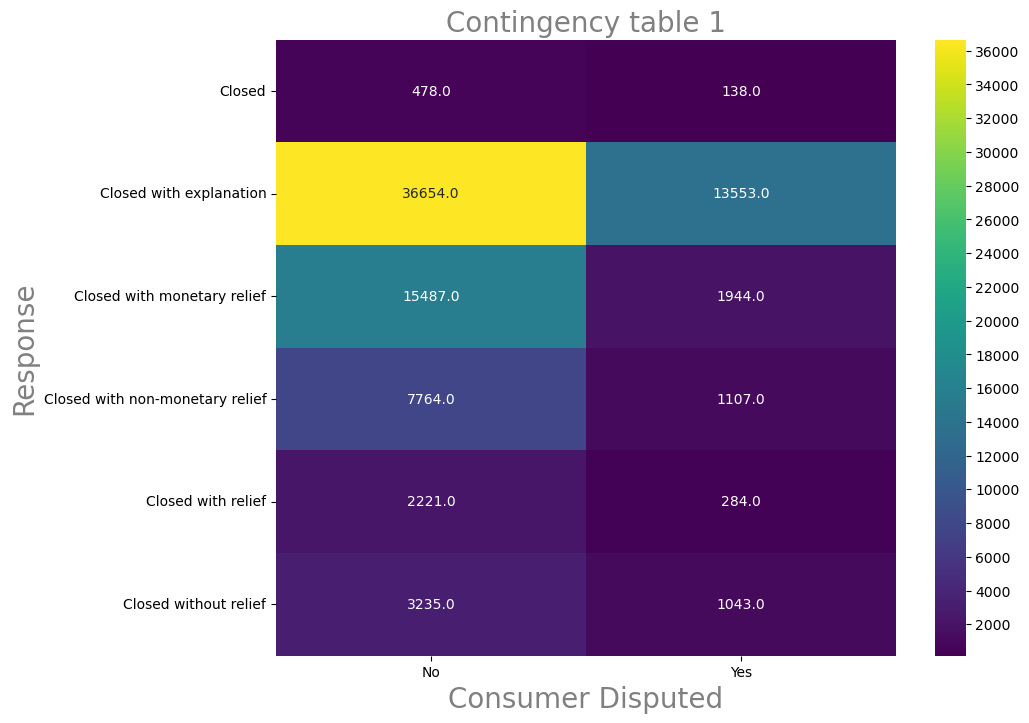

In [18]:
#create figure and set size
plt.figure(figsize = (10,8))

#create heatmap
sns.heatmap(contingency_table_response_type_vs_consumer_dispute ,annot = True,\
            fmt = '.1f',cmap = 'viridis',cbar_kws={'ticks': range(0,38001,2000)})

#Set labels and format of plot.
plt.title("Contingency table 1",color = 'gray', fontsize = 20)
plt.ylabel("Response",fontsize = 20,color = 'gray')
plt.xlabel("Consumer Disputed", fontsize =20, color = 'gray')

plt.show()

In [19]:
#Chi square test.
chi,p_value,dof,expected = chi2_contingency(contingency_table_response_type_vs_consumer_dispute )

#create expected df and set index and columns as index and column of contigency_table_response_type_vs_consumer_dispute
expected = pd.DataFrame(expected)
expected.columns = contingency_table_response_type_vs_consumer_dispute.columns
expected.index = contingency_table_response_type_vs_consumer_dispute.index
print(expected)
print("-"*100)
print("Chi-test: ",chi)
print("P-value: ",p_value)
print("Degree of freedom: ",dof)

consumer_disputed                          No           Yes
company_response_to_consumer                               
Closed                             483.348715    132.651285
Closed with explanation          39395.274265  10811.725735
Closed with monetary relief      13677.356259   3753.643741
Closed with non-monetary relief   6960.692294   1910.307706
Closed with relief                1965.565798    539.434202
Closed without relief             3356.762669    921.237331
----------------------------------------------------------------------------------------------------
Chi-test:  2603.098221793971
P-value:  0.0
Degree of freedom:  5


We define null-hypothesis and alternative hypothesis as:

* null-hypothesis : There is no significant relation between company response type and consumer disputes.
* alternative-hypothesis: There is significant relation between company response type and consumer disputes.

Here as well there is significant relationship between company response type and consumer disputes. In this case as well we reject null hypothesis and accept alternative hypothesis which states that there is a significant relationship between company response type and consumer disputes.

Again, for company response time we perform chi-test.
Here too we set:
* Null-hypothesis: There is no significant relation between company responded in time and consumer disputes.
* Alternative hypothesis: There is significant relationship between compnany responded in time and consumer disputes.

In [20]:
#create contingency table
contingency_table_timely_response_vs_consumer_dispute = pd.crosstab(index=rd_count['timely_response'],\
                                                                 columns=rd_count['consumer_disputed'])
contingency_table_timely_response_vs_consumer_dispute

consumer_disputed,No,Yes
timely_response,,
No,551,148
Yes,65288,17921


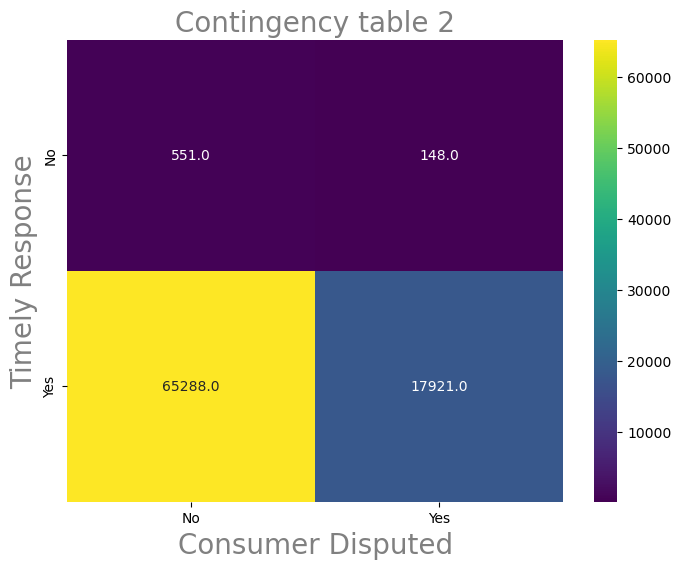

In [21]:
#create figure and set figure size
plt.figure(figsize =(8,6))

#create heatmap
sns.heatmap(contingency_table_timely_response_vs_consumer_dispute,annot = True,\
            fmt = '.1f',cmap = 'viridis')

#set label and format of plot.
plt.title("Contingency table 2",color = 'gray', fontsize = 20)
plt.ylabel("Timely Response",fontsize = 20,color = 'gray')
plt.xlabel("Consumer Disputed", fontsize =20, color = 'gray')

plt.show()

In [22]:
#calculate chi square test.
chi_t,p_value_t,dof_t,expected_t = chi2_contingency(contingency_table_timely_response_vs_consumer_dispute, correction=True)
expected_t = pd.DataFrame(expected_t)

#set expected_t index,column as contingency table index,column
expected_t.columns = contingency_table_timely_response_vs_consumer_dispute.columns
expected_t.index = contingency_table_timely_response_vs_consumer_dispute.index
print(expected_t)
print("-"*100)
print("Chi-test: ",chi_t)
print("P-value: ",p_value_t)
print("Degree of freedom: ",dof_t)

consumer_disputed            No           Yes
timely_response                              
No                   548.475247    150.524753
Yes                65290.524753  17918.475247
----------------------------------------------------------------------------------------------------
Chi-test:  0.035001730594665326
P-value:  0.8515920329964316
Degree of freedom:  1


From this we reject alternative hypothesis.There was nosignificant relationship between company responded on time with consumer disputes.


Now for analysis of consumer complaints we will clean complaints text and after through cleaning create plot to visualize the words used to get idea of most used words in the complaints.

In [23]:
#Create a df to store consumer complaint
consumer_complaint_narrative = credit_cards_complaints.consumer_complaint_narrative\
[credit_cards_complaints.consumer_complaint_narrative.notna()].reset_index(drop=True)

#clean unnecessary characters in the complaints of customer
words_used = [sentence.lower().split(" ")for sentence in consumer_complaint_narrative]
words_used = [re.sub(r'x{2,}|[^a-zA-Z\s]', "", str(word)) for word in words_used]
words_used = [re.sub(r'credit_card',"",word) for word in words_used]

#create string from all the words which is cleaned
words_used = ' '.join(words_used)

#create stopwords from nltk
stopwords = stopwords.words("english")

#create textblob object
textblob = TextBlob(words_used)

#words_used list containing all the words used in complaints
words_used = [word for word in textblob.words if word not in stopwords]


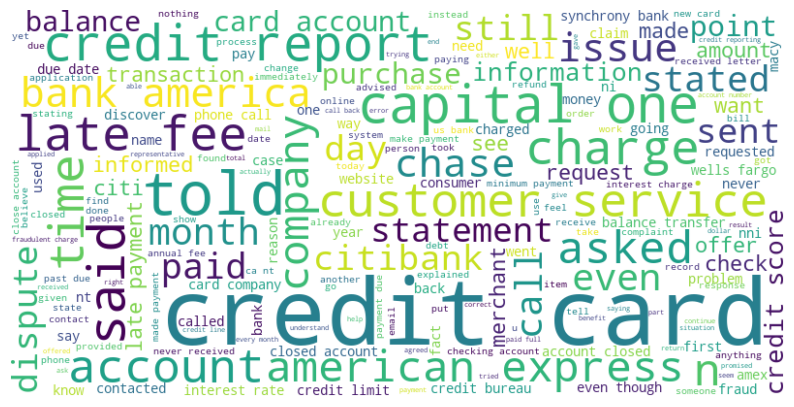

In [24]:
#again seperate words in word used as string with space as seperator
words_used = ' '.join(words_used)

#use wordcloud to create wordcloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_used)

#plot the wordcloud 
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


With above visualization we can get insights of words used in the complaints. We see the most used words are credit card,account,capital,credit report, time, customer service,late fee etc which can be very helpful in drafting in advance a proper scheme or plan for consumer.

In [69]:
response_time = pd.DataFrame(credit_cards_complaints.no_days_taken_to_respond.value_counts().rename("days"))
response_time

,days
0,43384
1,11425
2,7043
3,5487
4,4966
...,...
180,1
144,1
196,1
146,1
